# Unit15_Example_distillation | Distillation Column: DNN predicts ethanol molar concentration

本 Notebook 使用 `Part_4/data/distillation_column/dataset_distill.csv` 建立回歸模型，預測產品端 **ethanol molar concentration**（欄位：`Ethanol concentration`）。

資料來源: 
Kaggle Quality Prediction in a Mining Process
https://www.kaggle.com/datasets/jorgecote/distillation-column/

Cote-Ballesteros, J. E., Grisales Palacios, V. H., & Rodriguez-Castellanos, J. E. (2022). A Hybrid Approach Variable Selection Algorithm Based on Mutual Information for Data-Driven Industrial Soft-Sensor Applications. Ciencia E Ingenieria Neogranadina, 32(1), 59–70. https://doi.org/10.18359/rcin.5644

重點：
- 蒸餾塔多點溫度 + 流量資訊 -> 組成資料驅動 soft sensor
- Baseline（Ridge）vs DNN（MLP）性能比較
- 正確資料切分/標準化，避免 data leakage
- 訓練曲線、Parity/Residual plot 用於模型診斷


---
## 0. 環境設定

In [1]:
from pathlib import Path
import tensorflow as tf
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P4_Unit15_Example_Distillation'
SOURCE_DATA_DIR = 'distillation_column'

try:
  from google.colab import drive
  IN_COLAB = True
  print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
  drive.mount('/content/drive', force_remount=True)
except ImportError:
  IN_COLAB = False
  print("✓ 偵測到 Local 環境")
try:
  shortcut_path = '/content/CHE-AI-COURSE'
  os.remove(shortcut_path)
except FileNotFoundError:
  pass

if IN_COLAB:
  source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
  os.symlink(source_path, shortcut_path)
  shortcut_path = Path(shortcut_path)
  if source_path.exists():
    NOTEBOOK_DIR = shortcut_path / 'Part_4' / 'Unit15'
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'
  else:
    print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
  
else:
  NOTEBOOK_DIR = Path.cwd()
  OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
  DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
  MODEL_DIR = OUTPUT_DIR / 'models'
  FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")


# ========================================
# 檢查 GPU 狀態
# ========================================
print(f"\nTensorFlow Version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ 偵測到 GPU：{gpus[0].name}")
    print("  （訓練速度將明顯快於僅用 CPU）")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("△ 未偵測到 GPU。")
    print("  訓練速度將使用 CPU（速度較慢但仍可完成）")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\distillation_column
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation\figs

TensorFlow Version: 2.10.1
✓ 偵測到 GPU：/physical_device:GPU:0
  （訓練速度將明顯快於僅用 CPU）


## 數據下載

In [2]:
# 數據來源: Kaggle Quality Prediction in a Mining Process
# https://www.kaggle.com/api/v1/datasets/download/jorgecote/distillation-column

import requests
import os
import zipfile

# 1. 設定路徑與 URL
url = "https://www.kaggle.com/api/v1/datasets/download/jorgecote/distillation-column"
zip_path = os.path.join(DATA_DIR, "distillation-column.zip")
data_file = os.path.join(DATA_DIR, "dataset_distill.csv")
extract_path = DATA_DIR

def download_and_extract():
    # --- 步驟 A: 下載檔案 ---
    print(f"正在從 {url} 下載...")
    try:
        # allow_redirects=True 處理 Kaggle 的重導向
        response = requests.get(url, allow_redirects=True, stream=True)
        response.raise_for_status() # 若下載失敗會拋出異常
        
        with open(zip_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"下載成功，檔案儲存於: {zip_path}")

        # --- 步驟 B: 解壓縮檔案 ---
        if zipfile.is_zipfile(zip_path):
            print(f"正在解壓縮至: {extract_path}...")
            # 確保目標資料夾存在
            if not os.path.exists(extract_path):
                os.makedirs(extract_path)
            
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)
            
            print("解壓縮完成！")
            
            # (選填) 步驟 C: 刪除原始 ZIP 檔以節省空間
            # os.remove(zip_path)
            # print("已移除原始 ZIP 壓縮檔。")
        else:
            print("錯誤：下載的檔案不是有效的 ZIP 格式。")
            
    except Exception as e:
        print(f"發生錯誤: {e}")

if __name__ == "__main__" and not os.path.exists(data_file):
    download_and_extract()
else:
    print(f"檔案已存在於: {data_file}")

正在從 https://www.kaggle.com/api/v1/datasets/download/jorgecote/distillation-column 下載...
下載成功，檔案儲存於: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\distillation_column\distillation-column.zip
正在解壓縮至: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\data\distillation_column...
解壓縮完成！


In [3]:
# 基礎套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')
import joblib, pickle, json

# sklearn套件
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard

# 設定隨機種子
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 設定繪圖風格
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

TensorFlow version: 2.10.1
Keras version: 2.10.0


---
## 1) 讀取資料與欄位說明

資料欄位（單位依資料描述）：
- `Pressure`：塔壓 (bar)
- `T1`~`T14`：各塔板溫度 (K)
- `L`：Liquid flowrate
- `V`：Vapor flowrate
- `D`：Distillate flowrate
- `B`：Bottoms flowrate
- `F`：Feed flowrate
- `Ethanol concentration`：乙醇莫耳濃度 (target)

注意：原始 CSV 使用分號 `;` 作為分隔符號，且 `L`/`V` 欄位包含小數逗號科學記號（例如 `1,23E+08`），需先轉換為數值。


In [4]:
df = pd.read_csv(DATA_DIR / 'dataset_distill.csv', sep=';')
print('raw shape:', df.shape)
display(df.head())

# Convert L and V to numeric (decimal comma -> dot)
for col in ['L', 'V']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

print('dtypes:')
display(df.dtypes)
print('missing:')
display(df.isna().sum())

target_col = 'Ethanol concentration'
feature_cols = [c for c in df.columns if c != target_col]
print('n_features:', len(feature_cols), 'target:', target_col)
display(df[target_col].describe())


raw shape: (4408, 21)


,Pressure,T1,T2,T3,T4,T5,T6,T7,T8,T9,...,T11,T12,T13,T14,L,V,D,B,F,Ethanol concentration
0,1.01,350.89,350.95,351.01,351.08,351.16,351.26,351.38,351.54,351.78,...,353.00,355.19,363.77,371.47,780,1040,260,340,600,0.82076
1,1.01,350.86,350.91,350.96,351.02,351.09,351.17,351.28,351.43,351.66,...,352.76,354.66,362.20,370.98,780,1040,260,340,600,0.83253
2,1.01,350.85,350.89,350.93,350.99,351.05,351.13,351.23,351.37,351.58,...,352.55,354.13,360.16,370.10,780,1040,260,340,600,0.83953
3,1.01,350.84,350.88,350.92,350.97,351.03,351.11,351.21,351.34,351.53,...,352.40,353.75,358.45,368.99,780,1040,260,340,600,0.84366
4,1.01,350.83,350.87,350.91,350.96,351.02,351.09,351.18,351.31,351.49,...,352.30,353.50,357.23,367.81,780,1040,260,340,600,0.84622


dtypes:


Pressure                 float64
T1                       float64
T2                       float64
T3                       float64
T4                       float64
T5                       float64
T6                       float64
T7                       float64
T8                       float64
T9                       float64
T10                      float64
T11                      float64
T12                      float64
T13                      float64
T14                      float64
L                        float64
V                        float64
D                          int64
B                          int64
F                          int64
Ethanol concentration    float64
dtype: object

missing:


Pressure                 0
T1                       0
T2                       0
T3                       0
T4                       0
T5                       0
T6                       0
T7                       0
T8                       0
T9                       0
T10                      0
T11                      0
T12                      0
T13                      0
T14                      0
L                        0
V                        0
D                        0
B                        0
F                        0
Ethanol concentration    0
dtype: int64

n_features: 20 target: Ethanol concentration


count    4408.000000
mean        0.792205
std         0.076441
min         0.538190
25%         0.761890
50%         0.817520
75%         0.850280
max         0.891760
Name: Ethanol concentration, dtype: float64

---
## 2) EDA: 目標分佈與相關性（快速）

- 先看 `Ethanol concentration` 的分佈與尺度
- 再用 Pearson correlation 快速檢視線性關係（相關不等於因果）


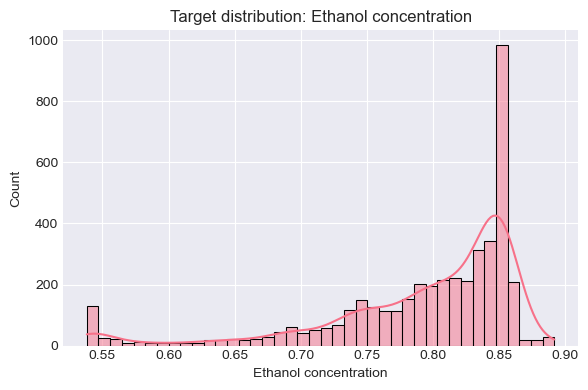

Ethanol concentration    1.000000
B                        0.320519
F                        0.272483
L                       -0.009334
V                       -0.009363
D                       -0.032578
T14                     -0.132484
T12                     -0.253807
T13                     -0.281439
T11                     -0.318123
T10                     -0.373304
T9                      -0.434553
T8                      -0.503237
T7                      -0.579956
T6                      -0.673202
T5                      -0.788148
T4                      -0.873145
T3                      -0.886038
T2                      -0.927970
T1                      -0.980998
Pressure                      NaN
Name: Ethanol concentration, dtype: float64

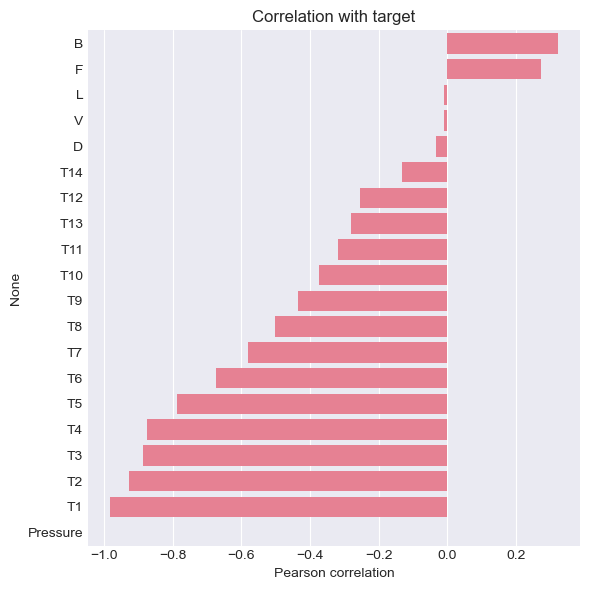

In [5]:
plt.figure(figsize=(6, 4))
sns.histplot(df[target_col], bins=40, kde=True)
plt.title('Target distribution: Ethanol concentration')
plt.xlabel(target_col)
plt.tight_layout()
plt.savefig(FIG_DIR / 'target_hist.png')
plt.show()

corr = df[feature_cols + [target_col]].corr(numeric_only=True)[target_col].sort_values(ascending=False)
display(corr)

plt.figure(figsize=(6, 6))
sns.barplot(x=corr.drop(target_col).values, y=corr.drop(target_col).index, orient='h')
plt.title('Correlation with target')
plt.xlabel('Pearson correlation')
plt.tight_layout()
plt.savefig(FIG_DIR / 'corr_bar.png')
plt.show()


---
## 3) Train/Valid/Test 切分與資料清理（避免 data leakage）

本範例採用 `train/valid/test = 70%/15%/15%`。

### 關於 L/V 欄位的極端值
資料中 `L`/`V` 會出現非常大的數值（例如 `1.23e8`、`1.23e9`）。若直接使用，可能造成尺度主導並降低模型穩定性。

示範做法：在訓練集上計算合理上限，並對 valid/test 套用相同上限做 clipping（只使用訓練集統計量，避免洩漏）。


In [6]:
X = df[feature_cols].to_numpy(dtype=np.float32)
y = df[target_col].to_numpy(dtype=np.float32)

X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.30, random_state=SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_tmp, y_tmp, test_size=0.50, random_state=SEED)

print('n_train:', X_train.shape[0], 'n_valid:', X_valid.shape[0], 'n_test:', X_test.shape[0])

# Clip extreme values for L and V based on train only
col_to_idx = {c: i for i, c in enumerate(feature_cols)}
lv_cols = ['L', 'V']
caps = {}
for c in lv_cols:
    idx = col_to_idx[c]
    train_vals = X_train[:, idx]
    # define a conservative cap: max value below 1e6
    below = train_vals[train_vals < 1e6]
    cap = float(below.max()) if below.size else float(np.quantile(train_vals, 0.99))
    caps[c] = cap
    for arr in [X_train, X_valid, X_test]:
        arr[:, idx] = np.clip(arr[:, idx], a_min=None, a_max=cap)
print('L/V caps:', caps)


n_train: 3085 n_valid: 661 n_test: 662
L/V caps: {'L': 22500.0, 'V': 22650.0}


---
## 4) 標準化與 Baseline: Ridge Regression

- `StandardScaler` 只對訓練集 `fit`
- Ridge 作為線性 baseline，方便比較 DNN 是否真的帶來提升


In [7]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s = scaler.transform(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
pred_ridge = ridge.predict(X_test_s)

mae_r = float(mean_absolute_error(y_test, pred_ridge))
rmse_r = float(np.sqrt(mean_squared_error(y_test, pred_ridge)))
r2_r = float(r2_score(y_test, pred_ridge))

print(f'Ridge  MAE : {mae_r:.6f}')
print(f'Ridge RMSE : {rmse_r:.6f}')
print(f'Ridge R2  : {r2_r:.6f}')


Ridge  MAE : 0.004795
Ridge RMSE : 0.007037
Ridge R2  : 0.992161


---
## 5) DNN (MLP) 回歸模型

- 使用Keras MLP + EarlyStopping

In [8]:
model = Sequential([
    Input(shape=(X_train_s.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1),
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='huber',
    metrics=[keras.metrics.MeanAbsoluteError(name='mae')],
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,057
Trainable params: 13,057
Non-trainable params: 0
_________________________________________________________________


In [9]:

callbacks = [
    EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, min_lr=1e-6),
]

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_valid_s, y_valid),
    epochs=500, batch_size=64, callbacks=callbacks, verbose=1
)


Epoch 1/500
49/49 [==============================] - 2s 8ms/step - loss: 0.0500 - mae: 0.1966 - val_loss: 0.0022 - val_mae: 0.0474 - lr: 0.0010
Epoch 2/500
49/49 [==============================] - 0s 4ms/step - loss: 0.0012 - mae: 0.0341 - val_loss: 5.3765e-04 - val_mae: 0.0229 - lr: 0.0010
Epoch 3/500
49/49 [==============================] - 0s 4ms/step - loss: 3.4944e-04 - mae: 0.0185 - val_loss: 2.1853e-04 - val_mae: 0.0150 - lr: 0.0010
Epoch 4/500
49/49 [==============================] - 0s 4ms/step - loss: 1.7009e-04 - mae: 0.0130 - val_loss: 1.3483e-04 - val_mae: 0.0114 - lr: 0.0010
Epoch 5/500
49/49 [==============================] - 0s 4ms/step - loss: 1.0707e-04 - mae: 0.0104 - val_loss: 1.0051e-04 - val_mae: 0.0102 - lr: 0.0010
Epoch 6/500
49/49 [==============================] - 0s 4ms/step - loss: 7.5543e-05 - mae: 0.0086 - val_loss: 7.5389e-05 - val_mae: 0.0085 - lr: 0.0010
Epoch 7/500
49/49 [==============================] - 0s 4ms/step - loss: 5.8629e-05 - mae: 0.0074 - 

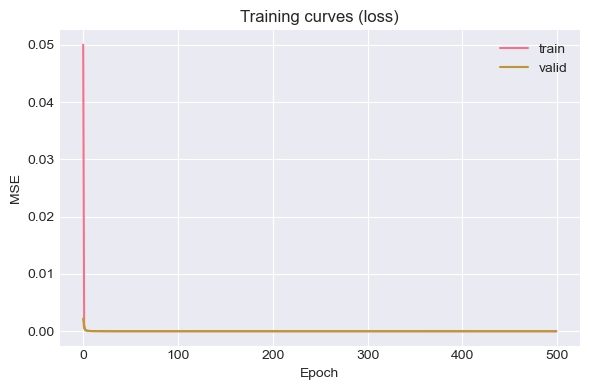

In [10]:

hist = pd.DataFrame(history.history)

plt.figure(figsize=(6, 4))
plt.plot(hist['loss'], label='train')
plt.plot(hist['val_loss'], label='valid')
plt.title('Training curves (loss)')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'loss_curve.png')
plt.show()


---
## 6) 評估: MAE / RMSE / R2 + Parity/Residual plots


In [11]:
pred_dnn = model.predict(X_test_s, verbose=0).reshape(-1)
mae = float(mean_absolute_error(y_test, pred_dnn))
rmse = float(np.sqrt(mean_squared_error(y_test, pred_dnn)))
r2 = float(r2_score(y_test, pred_dnn))

print(f'DNN   MAE : {mae:.6f}')
print(f'DNN  RMSE : {rmse:.6f}')
print(f'DNN   R2  : {r2:.6f}')

print()
print('(比較) Ridge baseline')
print(f'Ridge MAE : {mae_r:.6f}')
print(f'Ridge RMSE: {rmse_r:.6f}')
print(f'Ridge R2  : {r2_r:.6f}')

metrics = {
    'backend': 'tensorflow/keras',
    'n_train': int(X_train_s.shape[0]),
    'n_valid': int(X_valid_s.shape[0]),
    'n_test': int(X_test_s.shape[0]),
    'lv_caps': caps,
    'ridge': {'mae': mae_r, 'rmse': rmse_r, 'r2': r2_r},
    'dnn': {'mae': mae, 'rmse': rmse, 'r2': r2},
}
metrics_path = OUTPUT_DIR / 'metrics.json'
metrics_path.write_text(json.dumps(metrics, ensure_ascii=False, indent=2), encoding='utf-8')
print()
print('Saved metrics:', metrics_path)


DNN   MAE : 0.002049
DNN  RMSE : 0.004246
DNN   R2  : 0.997146

(比較) Ridge baseline
Ridge MAE : 0.004795
Ridge RMSE: 0.007037
Ridge R2  : 0.992161

Saved metrics: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation\metrics.json


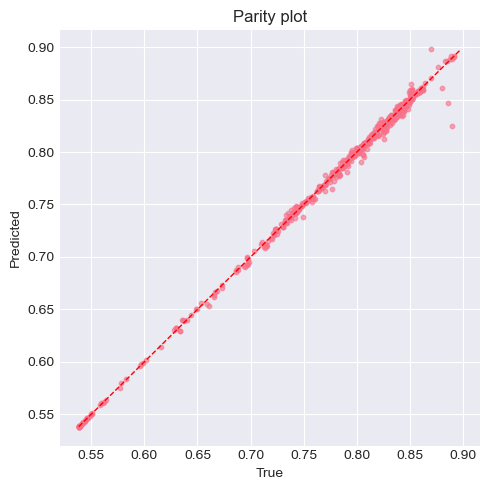

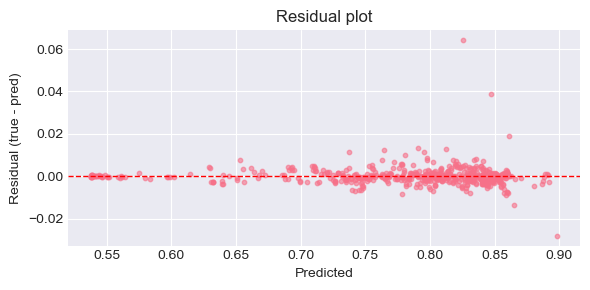

In [12]:
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pred_dnn, s=10, alpha=0.6)
min_v = float(min(y_test.min(), pred_dnn.min()))
max_v = float(max(y_test.max(), pred_dnn.max()))
plt.plot([min_v, max_v], [min_v, max_v], 'r--', linewidth=1)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('Parity plot')
plt.tight_layout()
plt.savefig(FIG_DIR / 'parity_plot.png')
plt.show()

residual = y_test - pred_dnn
plt.figure(figsize=(6, 3))
plt.scatter(pred_dnn, residual, s=10, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', linewidth=1)
plt.xlabel('Predicted')
plt.ylabel('Residual (true - pred)')
plt.title('Residual plot')
plt.tight_layout()
plt.savefig(FIG_DIR / 'residual_plot.png')
plt.show()


---
## 7) 預測分佈與特徵關係 (sanity check)

這裡用 holdout test set 做視覺化：
- `y_test` 的真實分佈 vs `pred_dnn` 預測分佈
- 預測值 vs 關鍵特徵 (例如 Pressure, T14)


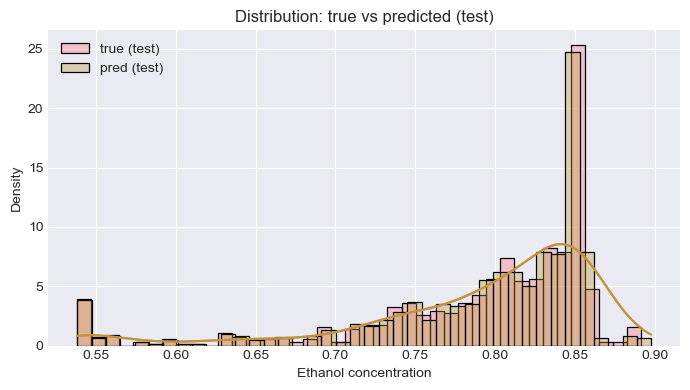

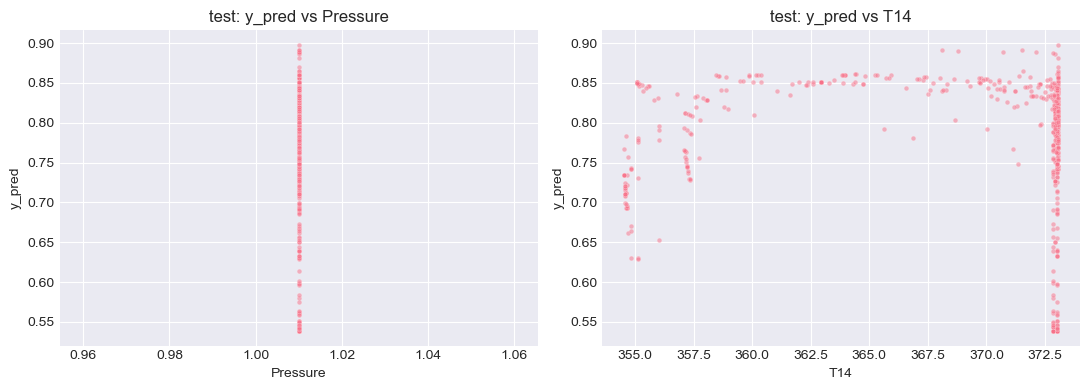

In [13]:
plt.figure(figsize=(7, 4))
sns.histplot(y_test, bins=40, stat='density', kde=True, color='C0', label='true (test)', alpha=0.35)
sns.histplot(pred_dnn, bins=40, stat='density', kde=True, color='C1', label='pred (test)', alpha=0.35)
plt.title('Distribution: true vs predicted (test)')
plt.xlabel(target_col)
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / 'test_true_vs_pred_dist.png')
plt.show()

test_df = pd.DataFrame(X_test, columns=feature_cols)
test_df['y_true'] = y_test
test_df['y_pred'] = pred_dnn

fig, axes = plt.subplots(1, 2, figsize=(11, 4))
sns.scatterplot(data=test_df, x='Pressure', y='y_pred', s=12, alpha=0.5, ax=axes[0])
axes[0].set_title('test: y_pred vs Pressure')
axes[0].set_xlabel('Pressure')
axes[0].set_ylabel('y_pred')

x_col = 'T14' if 'T14' in test_df.columns else 'T1'
sns.scatterplot(data=test_df, x=x_col, y='y_pred', s=12, alpha=0.5, ax=axes[1])
axes[1].set_title(f'test: y_pred vs {x_col}')
axes[1].set_xlabel(x_col)
axes[1].set_ylabel('y_pred')

plt.tight_layout()
plt.savefig(FIG_DIR / 'test_pred_scatter.png')
plt.show()


---
## 8) 保存模型與 scaler


In [14]:
model_path = MODEL_DIR / 'ethanol_dnn.keras'
model.save(model_path)
print('Saved model:', model_path)

scaler_path = MODEL_DIR / 'scaler.joblib'
joblib.dump(scaler, scaler_path)
print('Saved scaler:', scaler_path)


Saved model: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation\models\ethanol_dnn.keras
Saved scaler: d:\MyGit\CHE-AI-COURSE\Part_4\Unit15\outputs\P4_Unit15_Example_Distillation\models\scaler.joblib
